In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson, jarque_bera
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pd.get_data_yahoo = pdr.get_data_yahoo

## Step-1 Fetch the historical data 

In [2]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT']


df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2018-12-24,205.160004,94.129997
2018-12-26,222.949997,100.559998
2018-12-27,225.139999,101.180000
2018-12-28,223.130005,100.389999
2018-12-31,226.240005,101.570000


In [3]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

np.float64(0.04452696271616793)

As we can see, the p-value is less than 0.05, which means ADBE and MSFT are indeed cointegrated pairs

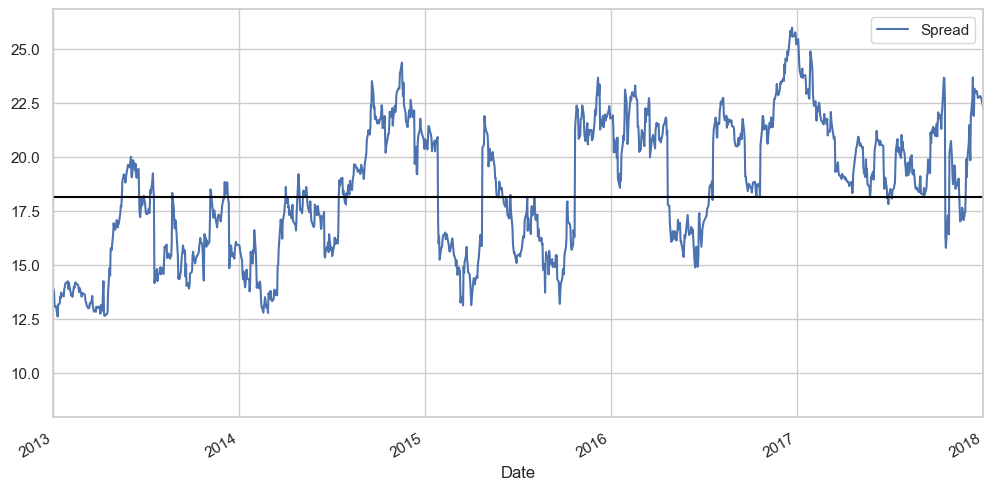

In [107]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
results.summary()
S1 = df['ADBE']
b = results.params['ADBE']

spread = S2- b*S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

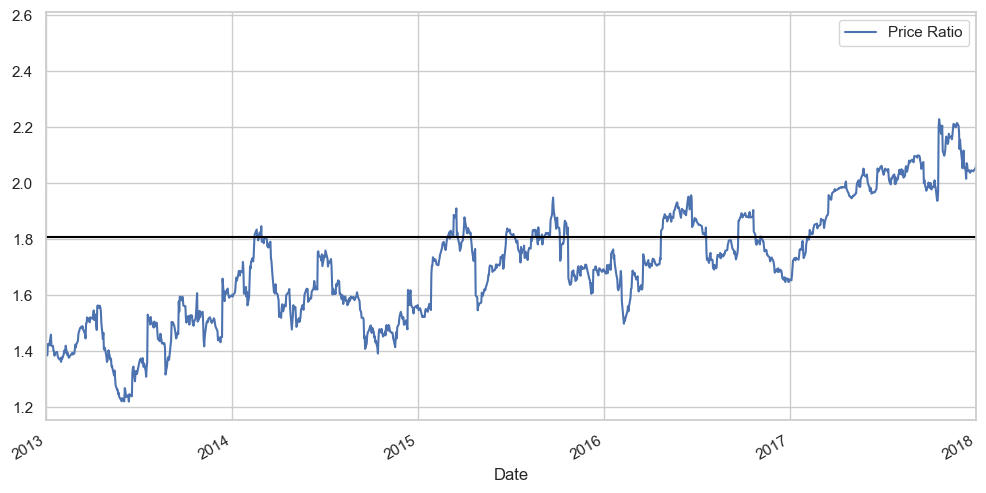

In [138]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

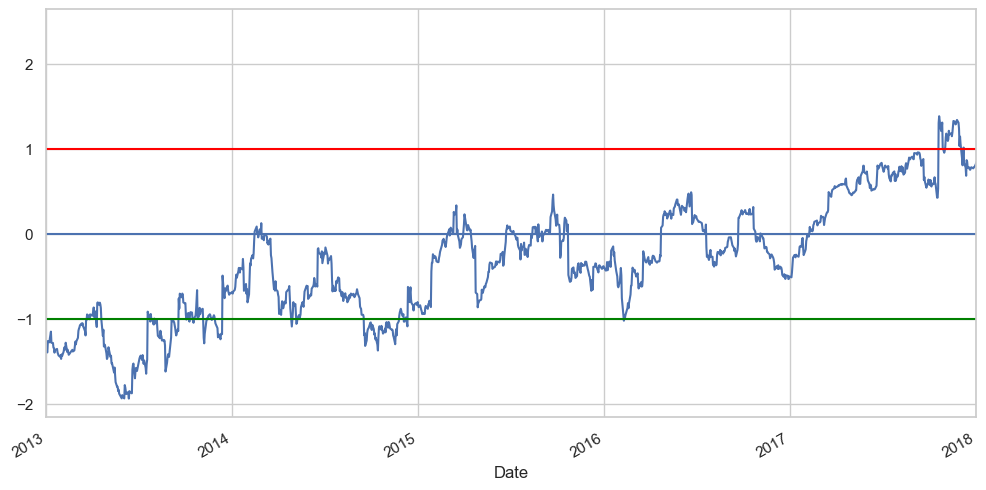

In [109]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

## Step-2 Feature Engineering 
- 5 day Moving Average of Ratio
- 20 day Moving Average of Ratio
- 60 day Moving Average of Ratio
- 5 day Rate of Change
- 20 day Rate of Change
- 60 day Rate of Change
- 20 day Standard Deviation
- 20 day Standard Deviation
- 1 day lag
- 5 day lag
- 20 day lag
- 60 day lag

In [110]:
ratios = df['ADBE'] / df['MSFT']

In [185]:
def feature_engineering(ratios):
    features = pd.DataFrame()
    
    # Moving Averages
    features['ratios_mavg5'] = ratios.rolling(window=5, center=False).mean()
    features['ratios_mavg20'] = ratios.rolling(window=20, center=False).mean()
    features['ratios_mavg60'] = ratios.rolling(window=60, center=False).mean()

    # Rate of Change (ROC)
    features['ratios_roc5'] = ratios.pct_change(periods=5)*100
    features['ratios_roc20'] = ratios.pct_change(periods=20)*100
    features['ratios_roc60'] = ratios.pct_change(periods=60)*100

    # Standard Deviation
    features['std_60'] = ratios.rolling(window=60, center=False).std()
    features['std_20'] = ratios.rolling(window=20, center=False).std()

    # Lag Features
    features['ratios_lag1'] = ratios.shift(1)
    features['ratios_lag5'] = ratios.shift(5)
    features['ratios_lag20'] = ratios.shift(20)
    features['ratios_lag60'] = ratios.shift(60)

    # y
    features['future_ratio'] = ratios.shift(-1)
    features = features.dropna()

    return features

In [186]:
features = feature_engineering(ratios)

## Step-3 Train Machine Learning Model

In [191]:
X = features.drop(columns=['future_ratio'])
Y = features['future_ratio']
X_train = X[:1057] 
X_test = X[1057:]
y_train = Y[:1057]
y_test = Y[1057:]

In [192]:
algorithms = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

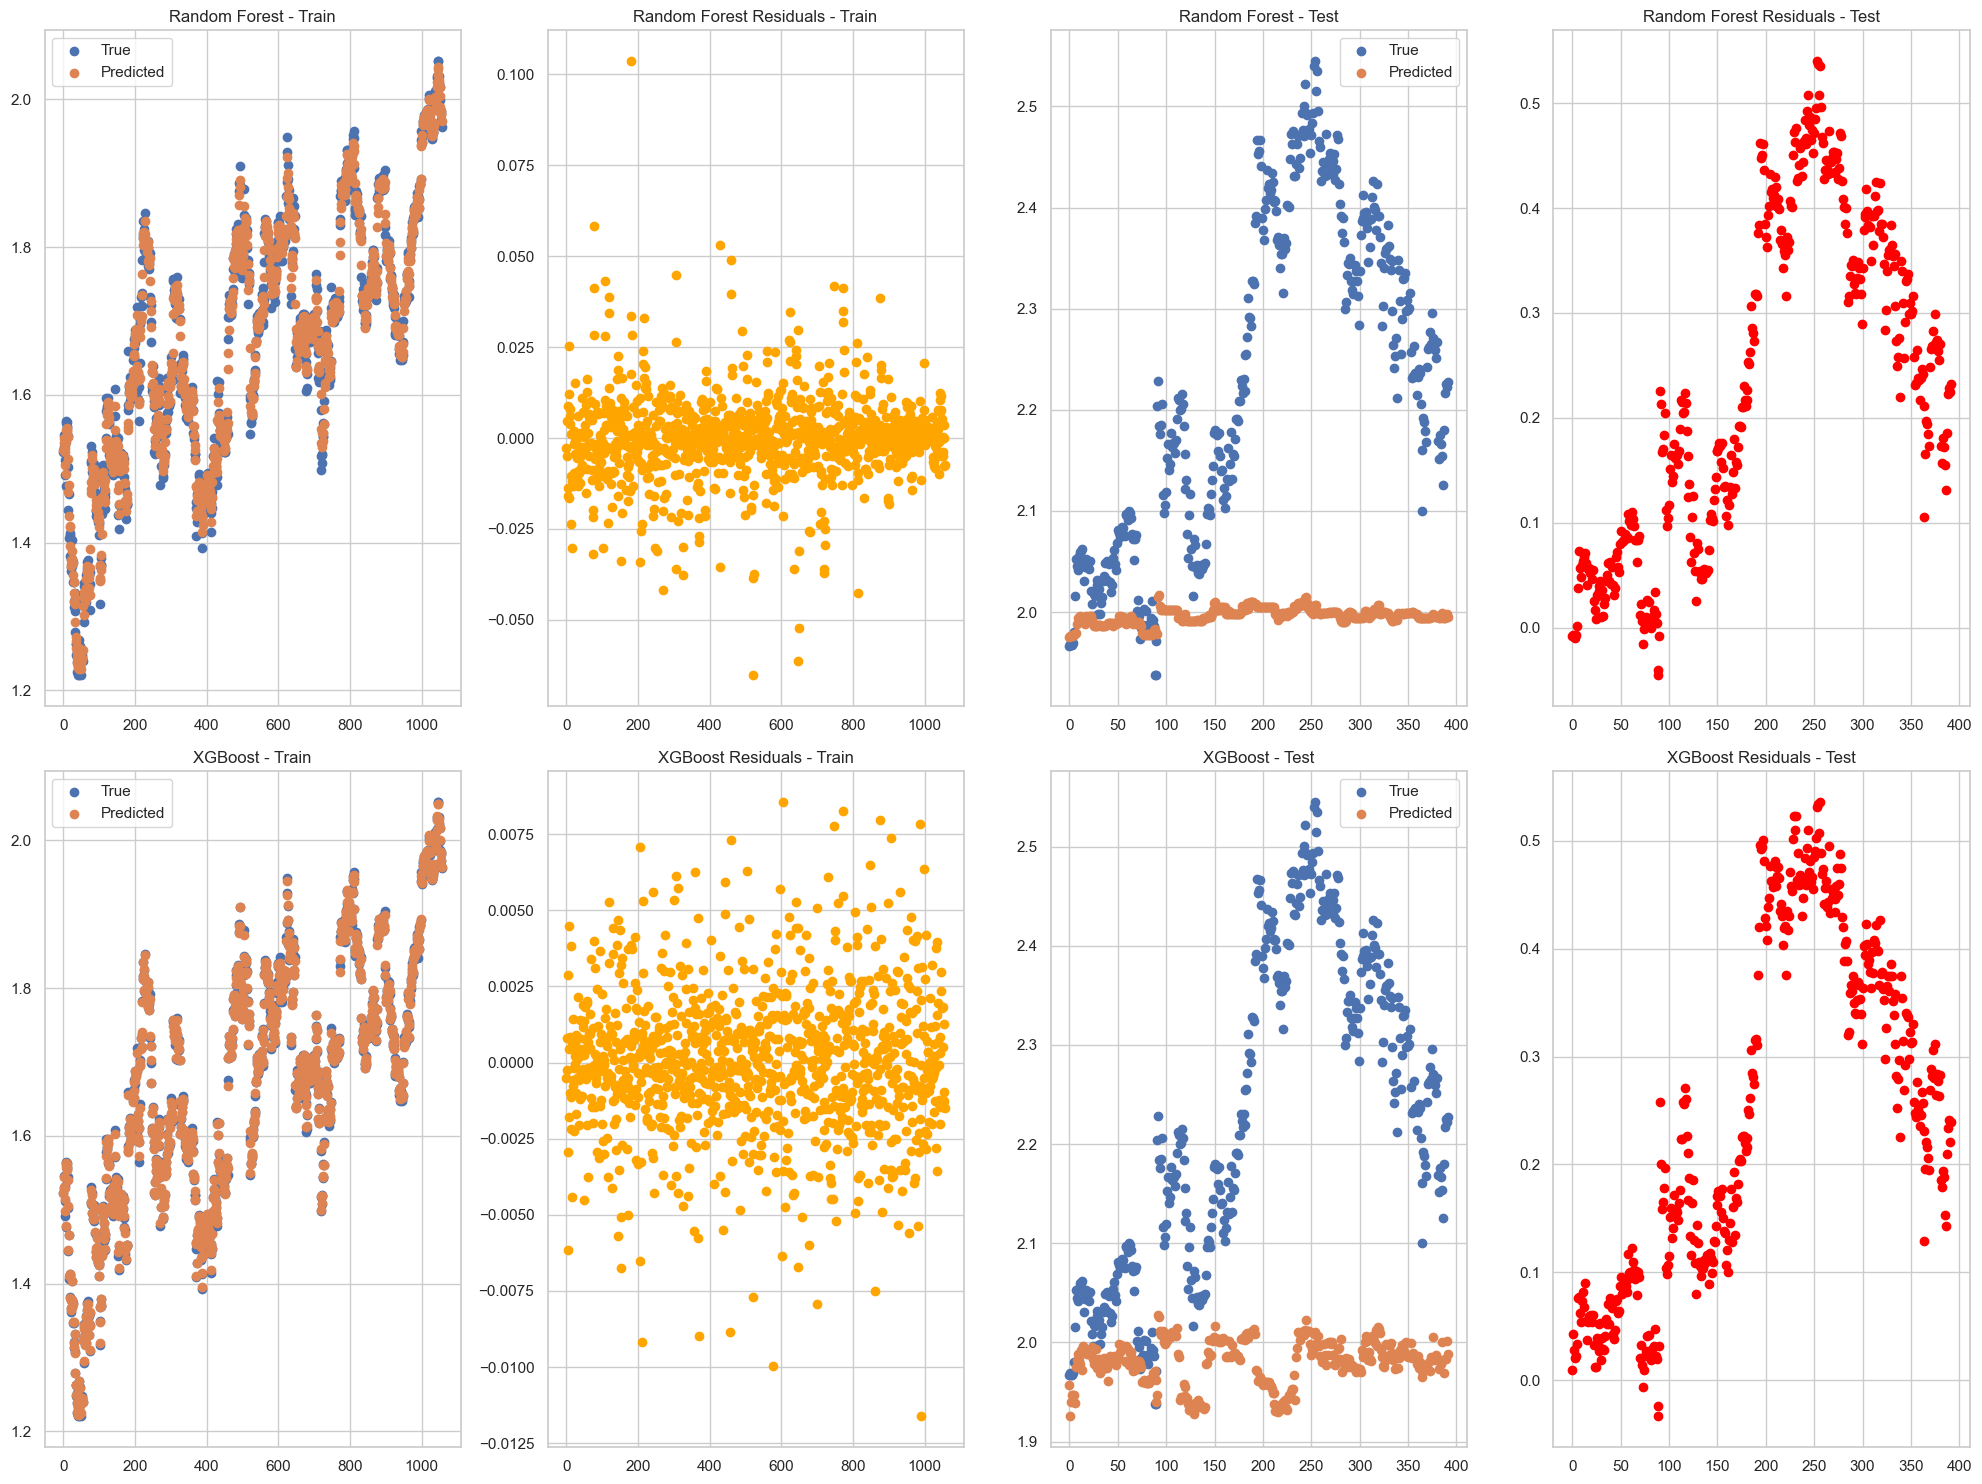

Train Metrics
               R-squared       MSE  Durbin-Watson  Jarque-Bera    JB P-value
Random Forest   0.995064  0.000144       1.319712  3701.205958  0.000000e+00
XGBoost         0.999804  0.000006       2.375325   162.543140  5.060643e-36

Test Metrics
               R-squared       MSE  Durbin-Watson  Jarque-Bera    JB P-value
Random Forest  -2.089455  0.079027       0.009853    28.495627  6.490128e-07
XGBoost        -2.413215  0.087309       0.010062    30.245121  2.706172e-07


In [193]:
# Initialize metric tables
metric_table_train = pd.DataFrame()
metric_table_test = pd.DataFrame()

# Define algorithms
algorithms = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Create a grid of subplots
fig, axs = plt.subplots(len(algorithms), 4, figsize=(20, 15))
fig_row = -1

# Loop through each algorithm
for algorithm_name, algorithm in algorithms.items():

    # Train the model
    algorithm.fit(X_train, y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train)

    # Test predictions
    y_test_pred = algorithm.predict(X_test)

    # Train metrics
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)

    # Test metrics
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Additional metrics
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)

    durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
    jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)

    # Update metric tables
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'MSE'] = mse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

    metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
    metric_table_test.at[algorithm_name, 'MSE'] = mse_test
    metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
    metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
    metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test

    # Create the plots
    fig_row += 1

    axs[fig_row, 0].scatter(range(len(y_train)), y_train, label='True')
    axs[fig_row, 0].scatter(range(len(y_train_pred)), y_train_pred, label='Predicted')
    axs[fig_row, 0].set_title(algorithm_name + " - Train")
    axs[fig_row, 0].legend()

    axs[fig_row, 1].scatter(range(len(residuals_train)), residuals_train, color='orange')
    axs[fig_row, 1].set_title(algorithm_name + " Residuals - Train")

    axs[fig_row, 2].scatter(range(len(y_test)), y_test, label='True')
    axs[fig_row, 2].scatter(range(len(y_test_pred)), y_test_pred, label='Predicted')
    axs[fig_row, 2].set_title(algorithm_name + " - Test")
    axs[fig_row, 2].legend()

    axs[fig_row, 3].scatter(range(len(residuals_test)), residuals_test, color='red')
    axs[fig_row, 3].set_title(algorithm_name + " Residuals - Test")

plt.tight_layout()
plt.show()

# Display metric tables
print("Train Metrics")
print(metric_table_train)
print("\nTest Metrics")
print(metric_table_test)


### Observations 
- As Nimay pointed out, we will ignore test metrics since overfitting is expected.
- XGBoost has performed exceptionally well on the train data with an 𝑅2 value near 1, so will choose this for further steps.

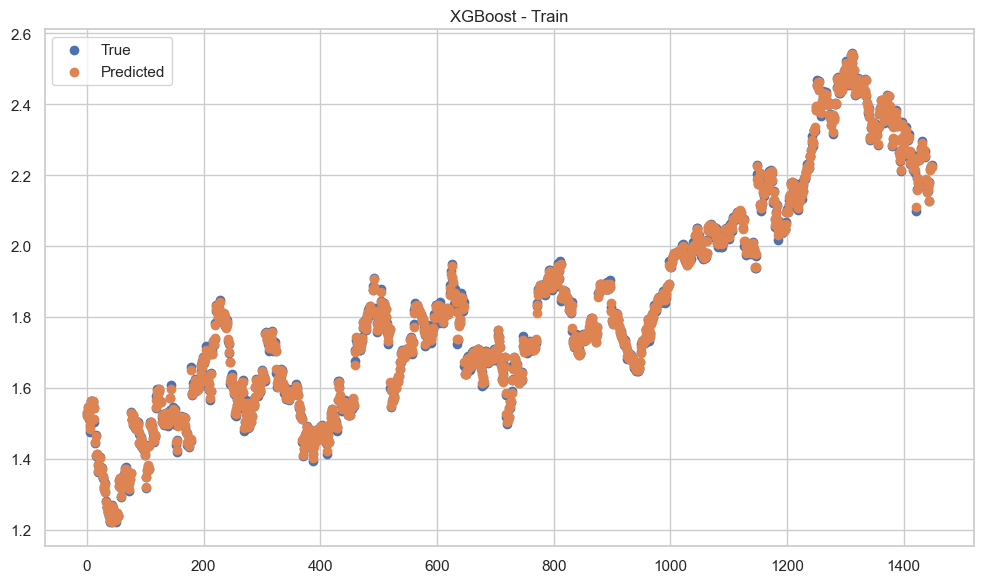

0.9998009572422616 1.7829781860098334e-05


In [205]:
X_train2 = X
Y_train2 = Y

algorithm = XGBRegressor(n_estimators=100, random_state=42).fit(X_train2, Y_train2)
y_train2_pred = algorithm.predict(X_train2)

r2_train = r2_score(Y_train2, y_train2_pred)
mse_train = mean_squared_error(Y_train2, y_train2_pred)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))  # Adjust rows and columns as needed
axs.scatter(range(len(Y_train2)), Y_train2, label='True')
axs.scatter(range(len(y_train2_pred)), y_train2_pred, label='Predicted')
axs.set_title("XGBoost - Train")
axs.legend()
plt.tight_layout()
plt.show()

print(r2_train, mse_train)


## Step-4 Generate Trading Signals

In [251]:
print(len(ratios))
print(len(Y_train2))

1510
1449


### Why 1449?
- The rolling window of size 60 introduces 59 NaN at the start.
- The 60 day lag introduces 60 NaN at the a
- The largest shift(-1) introduces 1 NaN at the end.

Total Rows Dropped: 61


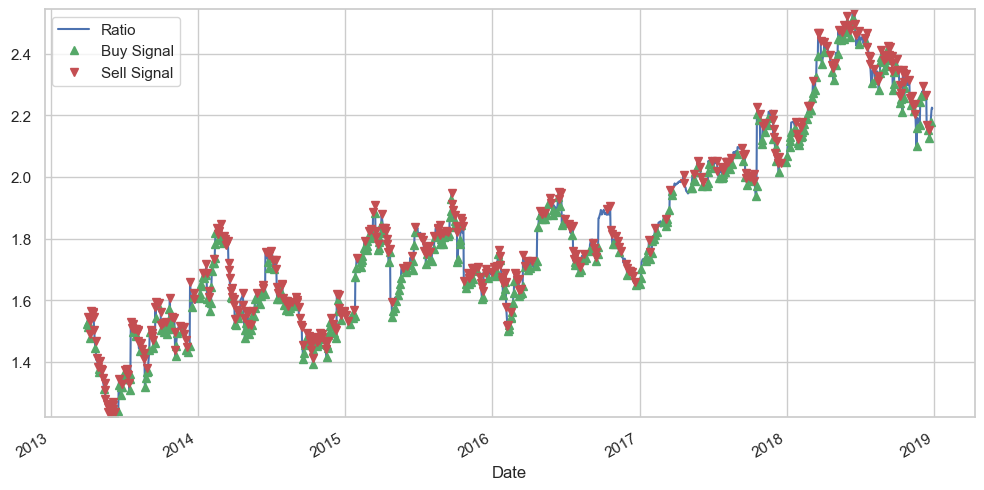

In [287]:
train = ratios.iloc[60:1509]
train.plot(figsize=(12,6))
buy = train.copy()
sell = train.copy()
buy.loc[y_train2_pred <= train * 1.005] = 0
sell.loc[y_train2_pred >= train * 0.995] = 0
buy.plot(color='g', linestyle='None', marker='^', label='Buy Signal')
sell.plot(color='r', linestyle='None', marker='v', label='Sell Signal')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, train.min(), train.max()))
# Add legend and show plot
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()


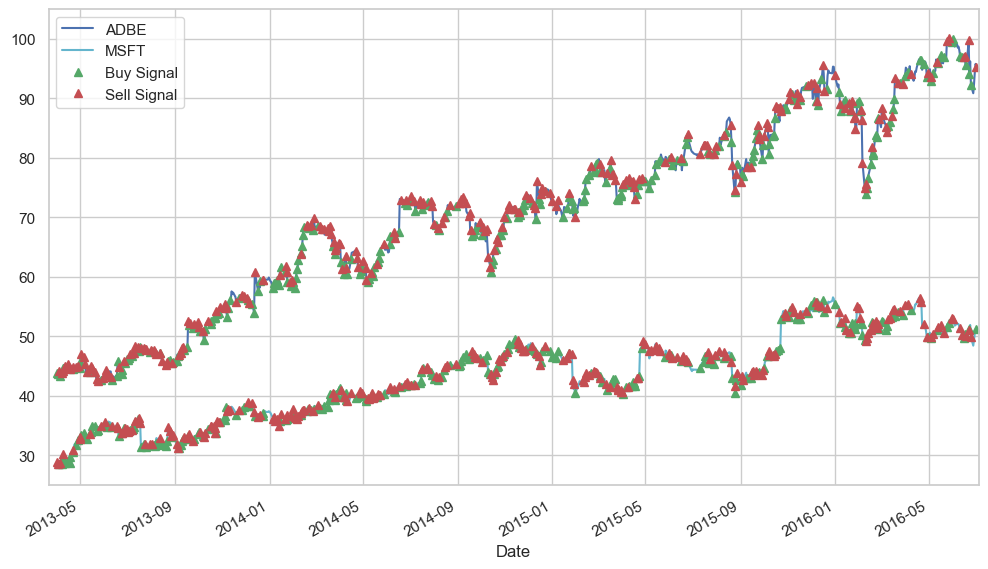

In [288]:
plt.figure(figsize=(12,7))
S1 = df['ADBE'].iloc[60:1509]
S2 = df['MSFT'].iloc[60:1509]

S1.plot(color='b')
S2.plot(color='c')

buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR.plot(color='g', linestyle='None', marker='^')
sellR.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 105)
plt.xlim('2013-03-22', '2016-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [291]:
def trade(S1, S2, y_train2_pred, train):

    ratios = S1 / S2

    money = 0
    countS1 = 0
    countS2 = 0
     
    for i in range(len(ratios)):
        # Sell short the ratio if y_train2_pred >= train * 1.02
        if y_train2_pred[i] >= train[i] * 1.005:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1  # Buy S1
            countS2 -= ratios[i]  # Sell S2

        # Buy long the ratio if y_train2_pred <= train * 0.98
        elif y_train2_pred[i] <= train[i] * 0.995:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1  # Sell S1
            countS2 += ratios[i]  # Buy S2
            
        # Clear positions if neither buy nor sell signal is triggered
        elif train[i] * 0.995 < y_train2_pred[i] < train[i] * 1.005:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money


In [292]:
trade(df['ADBE'].iloc[60:1509], df['MSFT'].iloc[60:1509], y_train2_pred, train)

np.float64(1171.2101045783895)